In [1]:
#!pip install tensorflow==2.0
#pip install -U --force-reinstall charset-normalizer
#pip install jupyterthemes
#pip install scikit-image

In [1]:
import os
os.path.abspath("")

'C:\\Users\\balur\\UTA\\Networks'

In [2]:
import tensorflow as tf
from tensorflow import keras

C:\Users\balur\anaconda3\envs\spark2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
# import the necessary packages
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [5]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them.

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

import gc
gc.enable()

In [7]:
# Train and test directories
path = "C:/Users/balur/OneDrive/Desktop/UTA/Sem-2/Network's/Project/"
train_image_dir = path + "train_v2"
test_image_dir = path + "test_v2"

In [8]:
train_images = os.listdir(train_image_dir)
train_images.sort()
print(f"Total of {len(train_images)} images in train directory.\nHere is how first five train_images looks like:- {train_images[:5]}")

Total of 12 images in train directory.
Here is how first five train_images looks like:- ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


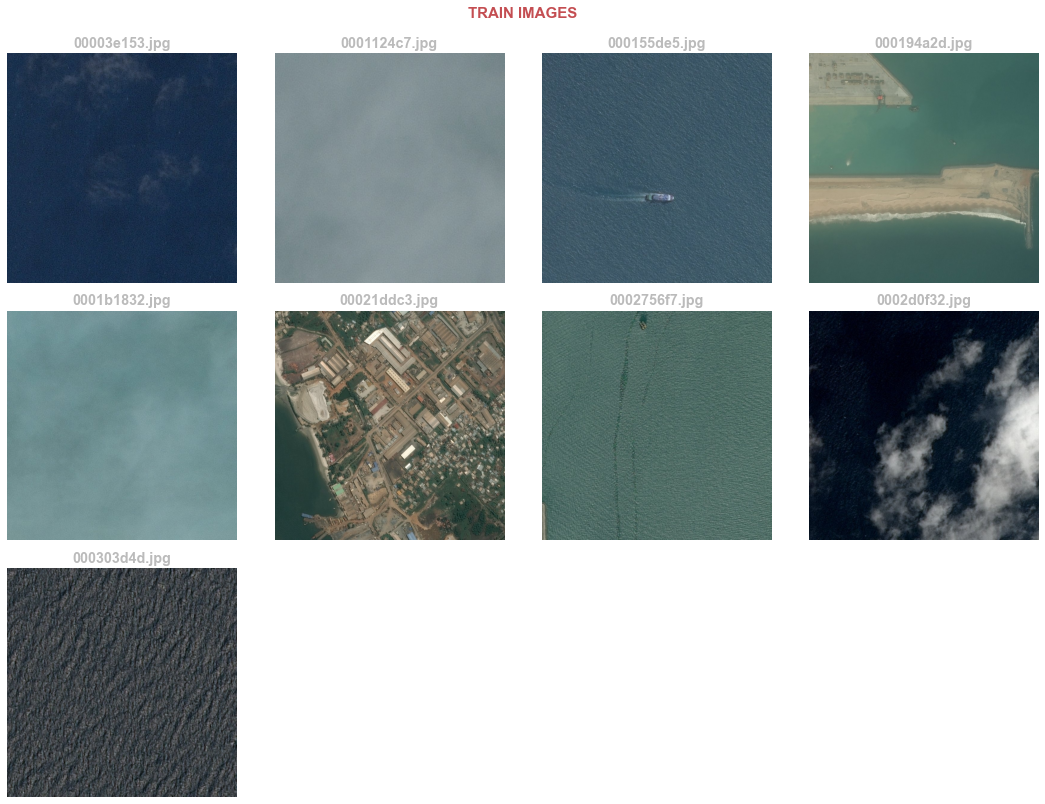

In [9]:
plt.figure(figsize=(15,15))
plt.suptitle('TRAIN IMAGES\n', weight = 'bold', fontsize = 15, color = 'r')
for i in range(9):
    plt.subplot(4, 4, i+1)
    plt.imshow(imread(train_image_dir + "/" + train_images[i]))
    plt.title(f"{train_images[i]}", weight = 'bold')
    plt.axis('off')
plt.tight_layout()

In [10]:
# Train ships segmented masks
masks = pd.read_csv(path + "train_ship_segmentations_v2.csv")
masks.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [11]:
row_rle = ['10 1', 
           '4 1 2 0 4 1', 
           '3 1 4 0 3 1', 
           '2 1 6 0 2 1',
           '1 1 2 0 1 1 2 0 1 1 2 0 1 1', 
           '1 1 8 0 1 1', 
           '3 1 1 0 2 1 1 0 3 1', 
           '2 1 1 0 1 1 2 0 1 1 1 0 2 1', 
           '1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1', 
           '10 1',
           'Total']

pixels = [len(row.split(" ")) for row in row_rle if row != 'Total']
sum_pixels = np.array(pixels).sum()
pixels.append(sum_pixels)

data = {
    'Row - RLE' : row_rle,
    'Pixels' : pixels
}

rle_df = pd.DataFrame(data)
rle_df.index+=1
rle_df

Row - RLE  Pixels
1                                  10 1       2
2                           4 1 2 0 4 1       6
3                           3 1 4 0 3 1       6
4                           2 1 6 0 2 1       6
5           1 1 2 0 1 1 2 0 1 1 2 0 1 1      14
6                           1 1 8 0 1 1       6
7                   3 1 1 0 2 1 1 0 3 1      10
8           2 1 1 0 1 1 2 0 1 1 1 0 2 1      14
9   1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1      18
10                                 10 1       2
11                                Total      84

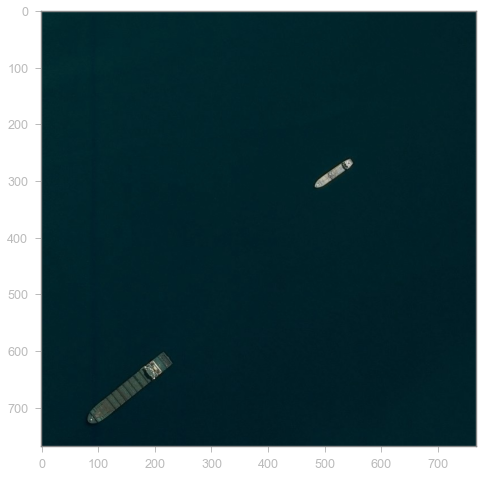

In [12]:
# Let us now see how it works for Image id:- 0005d01c8.jpg we have in the mask data frame

# Original image from training set
img_arr = imread(train_image_dir + '/' + '0005d01c8.jpg')
plt.figure(figsize=(15,8))
plt.imshow(img_arr)
plt.show()

In [13]:
img_arr.shape

(768, 768, 3)

In [14]:
# Filter out all 0005d01c8.jpg image ids and respective encoded data 
# 2 ships means 2 same image ids will be there!
rle_0 = masks.query('ImageId=="0005d01c8.jpg"')['EncodedPixels']
rle_0

29    56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30    365871 1 366638 3 367405 6 368173 7 368940 9 3...
Name: EncodedPixels, dtype: object

In [15]:
# Make a list of each mask shown above also visualise whats happening!
mask_lst, ct = [], 1
for mask in rle_0:
    print(f"Mask {ct} -\n{mask}\n\n")
    mask_lst.append(mask)
    ct+=1

Mask 1 -
56010 1 56777 3 57544 6 58312 7 59079 9 59846 11 60613 14 61380 16 62148 17 62915 19 63682 22 64449 24 65216 26 65984 27 66751 30 67518 32 68285 34 69052 36 69820 38 70587 40 71354 42 72121 42 72888 42 73656 42 74423 42 75190 42 75957 42 76724 42 77492 42 78259 42 79026 42 79793 42 80560 42 81328 42 82095 42 82862 42 83629 42 84396 42 85164 42 85931 42 86698 42 87465 42 88232 42 89000 42 89767 42 90534 42 91301 42 92068 42 92836 42 93603 42 94370 42 95137 42 95904 42 96672 42 97439 42 98206 42 98973 42 99740 42 100508 42 101275 42 102042 42 102809 42 103576 42 104344 42 105111 42 105878 42 106645 42 107412 42 108180 42 108947 42 109714 42 110481 42 111249 41 112016 42 112783 42 113550 42 114317 42 115085 41 115852 42 116619 42 117386 42 118153 42 118921 41 119688 42 120455 42 121222 42 121989 42 122757 41 123524 42 124291 42 125058 42 125825 42 126593 42 127360 42 128127 42 128894 42 129661 42 130429 42 131196 42 131963 42 132730 42 133497 42 134265 42 135032 42 135799 42 1365

In [16]:
# Split and Display how the first mask in the list looks like
split = mask_lst[0].split()
print(split)

['56010', '1', '56777', '3', '57544', '6', '58312', '7', '59079', '9', '59846', '11', '60613', '14', '61380', '16', '62148', '17', '62915', '19', '63682', '22', '64449', '24', '65216', '26', '65984', '27', '66751', '30', '67518', '32', '68285', '34', '69052', '36', '69820', '38', '70587', '40', '71354', '42', '72121', '42', '72888', '42', '73656', '42', '74423', '42', '75190', '42', '75957', '42', '76724', '42', '77492', '42', '78259', '42', '79026', '42', '79793', '42', '80560', '42', '81328', '42', '82095', '42', '82862', '42', '83629', '42', '84396', '42', '85164', '42', '85931', '42', '86698', '42', '87465', '42', '88232', '42', '89000', '42', '89767', '42', '90534', '42', '91301', '42', '92068', '42', '92836', '42', '93603', '42', '94370', '42', '95137', '42', '95904', '42', '96672', '42', '97439', '42', '98206', '42', '98973', '42', '99740', '42', '100508', '42', '101275', '42', '102042', '42', '102809', '42', '103576', '42', '104344', '42', '105111', '42', '105878', '42', '10664

In [17]:
# Grab all the starting pixels and lenghts and convert it into integers using numpy 
starts, lengths = [np.array(x, dtype = int) for x in (split[::2], split[1::2])]
starts, lengths

(array([ 56010,  56777,  57544,  58312,  59079,  59846,  60613,  61380,
         62148,  62915,  63682,  64449,  65216,  65984,  66751,  67518,
         68285,  69052,  69820,  70587,  71354,  72121,  72888,  73656,
         74423,  75190,  75957,  76724,  77492,  78259,  79026,  79793,
         80560,  81328,  82095,  82862,  83629,  84396,  85164,  85931,
         86698,  87465,  88232,  89000,  89767,  90534,  91301,  92068,
         92836,  93603,  94370,  95137,  95904,  96672,  97439,  98206,
         98973,  99740, 100508, 101275, 102042, 102809, 103576, 104344,
        105111, 105878, 106645, 107412, 108180, 108947, 109714, 110481,
        111249, 112016, 112783, 113550, 114317, 115085, 115852, 116619,
        117386, 118153, 118921, 119688, 120455, 121222, 121989, 122757,
        123524, 124291, 125058, 125825, 126593, 127360, 128127, 128894,
        129661, 130429, 131196, 131963, 132730, 133497, 134265, 135032,
        135799, 136566, 137333, 138101, 138868, 139635, 140402, 

In [18]:
# Get the ending pixels. 
'''Examples:- 
56010 1 ---> Starts at 56010 and ends at 56010
56777 3 ---> Starts at 56777 and ends at 56779
57544 6 ---> Starts at 57544 and ends at 57549'''
ends = starts + lengths - 1
pd.DataFrame({
    'Starts' : starts,
    'Lengths' : lengths,
    'Ends' : ends
}).head(10)

Starts  Lengths   Ends
0   56010        1  56010
1   56777        3  56779
2   57544        6  57549
3   58312        7  58318
4   59079        9  59087
5   59846       11  59856
6   60613       14  60626
7   61380       16  61395
8   62148       17  62164
9   62915       19  62933

In [19]:
# Create 1s in place of these pixels and rest should be 0
img = np.zeros(768*768, dtype = np.uint8)
for start, end in zip(starts, ends):
    img[start:end+1] = 1

In [20]:
# Check how output looks
img[56776:56781] # Should output 0, 1 , 1, 1 ,0 as we know 56777, 56778, 56779 ---> 1 and 5676, 56780 ---> 0

array([0, 1, 1, 1, 0], dtype=uint8)

In [21]:
# Copy-Paste this idea for another ship in the image
split_1 = mask_lst[1].split()                                                                # Split the mask into start_pixels and lengths
starts, lengths = [np.array(x, dtype = int) for x in (split_1[0:][::2], split_1[1:][::2])]   # Generate arrays from only starts and lengths
ends = starts + lengths - 1                                                                  # Start pixel to end pixel will be start - 1 + length
img1 = np.zeros(768*768, dtype = np.uint8)                                                   # 1D array containing all zeros
for start, end in zip(starts, ends):                                                         # For each start to end pair
    img1[start:end+1] = 1  

In [22]:
# Reshaping both the ship masks and combining it to form the final mask!
img = img.reshape(768, 768)
img1 = img1.reshape(768, 768)
final = img+img1
print(final, '\n\n', final.shape, '\n\n', final.ndim)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

 (768, 768) 

 2


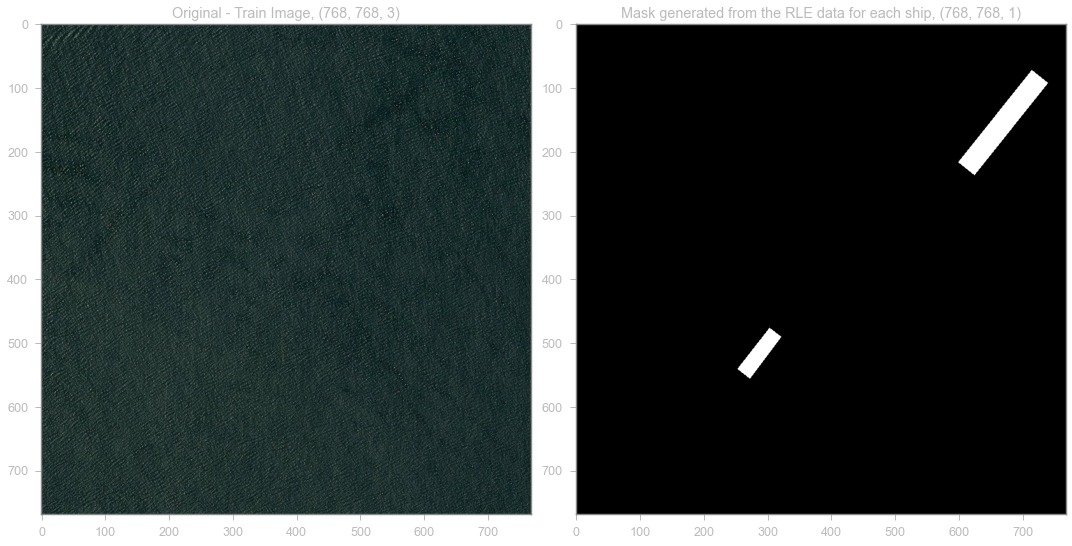

In [23]:
# Expand dimension of this array to have only 1 channel in the mask and visualise original and final mask
final = np.expand_dims(final, -1) # -1 means the last available dimenstion, in this case it is 2. Hence, on axis = 2 we will get 1.
original = imread(train_image_dir+'/'+train_images[10])
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "gray")
plt.tight_layout()
plt.show()

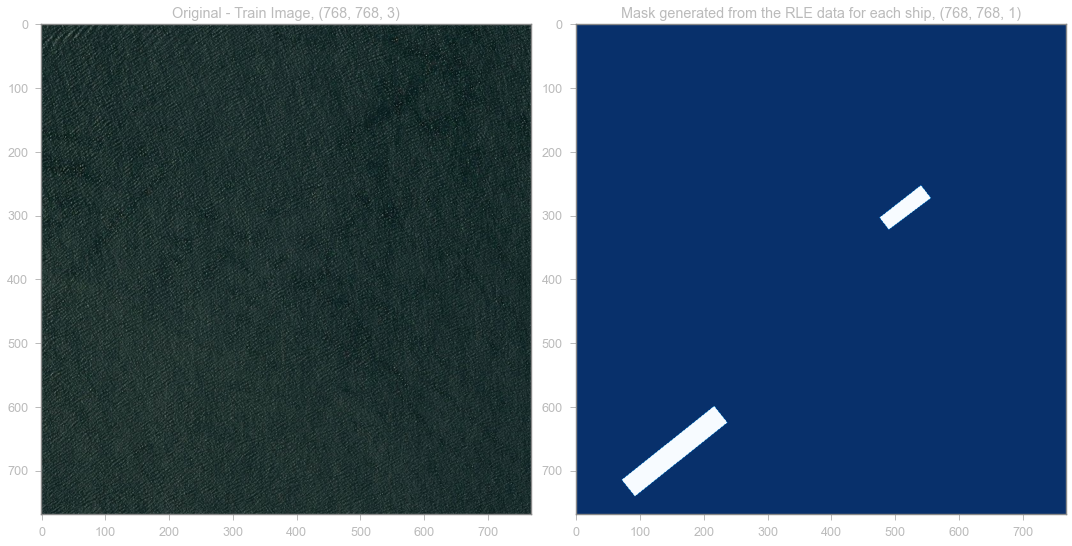

In [24]:
# Copy Paste the code from the prev cell with one change - Transpose!
img = img.reshape(768, 768).T     # Transpose the first ship mask
img1 = img1.reshape(768, 768).T   # Transpose the second ship mask
final = img+img1                  # Generate the final mask with two ships 
final = np.expand_dims(final, -1) 
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "Blues_r")
plt.tight_layout()
plt.show()

In [25]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T                                                       

def masks_as_image(in_mask_list):
    '''
    Input - 
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle 
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns - 
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

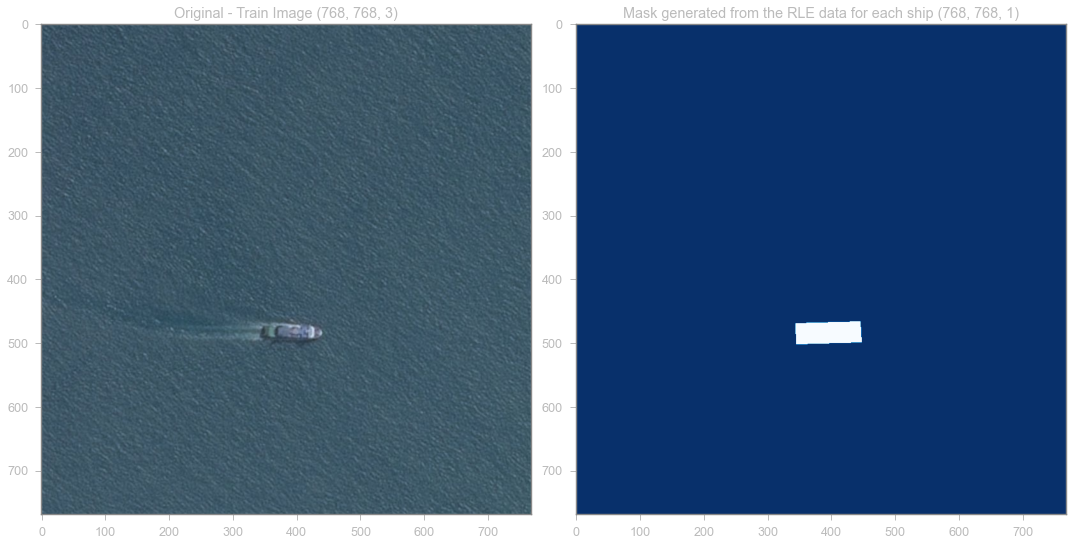

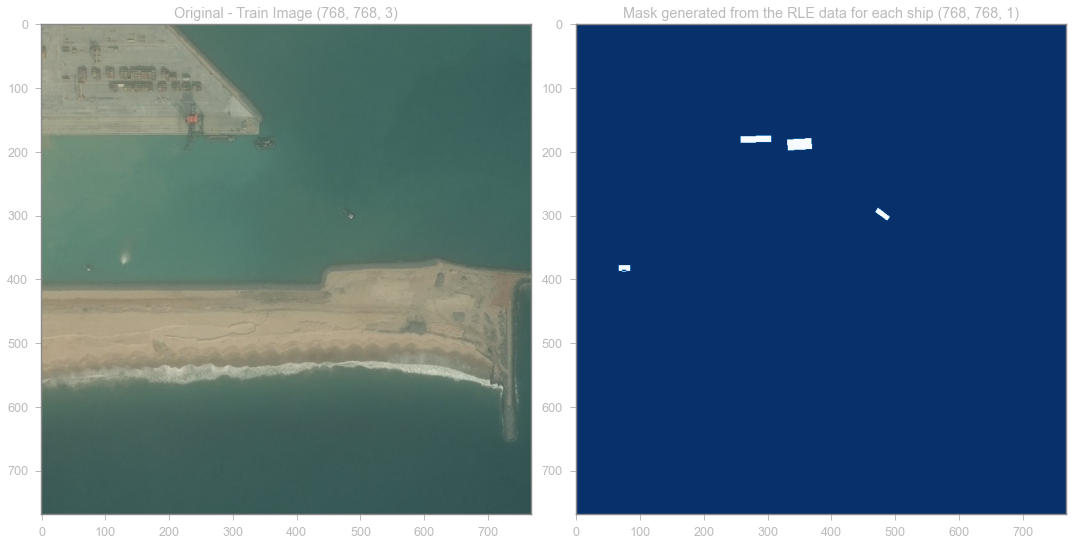

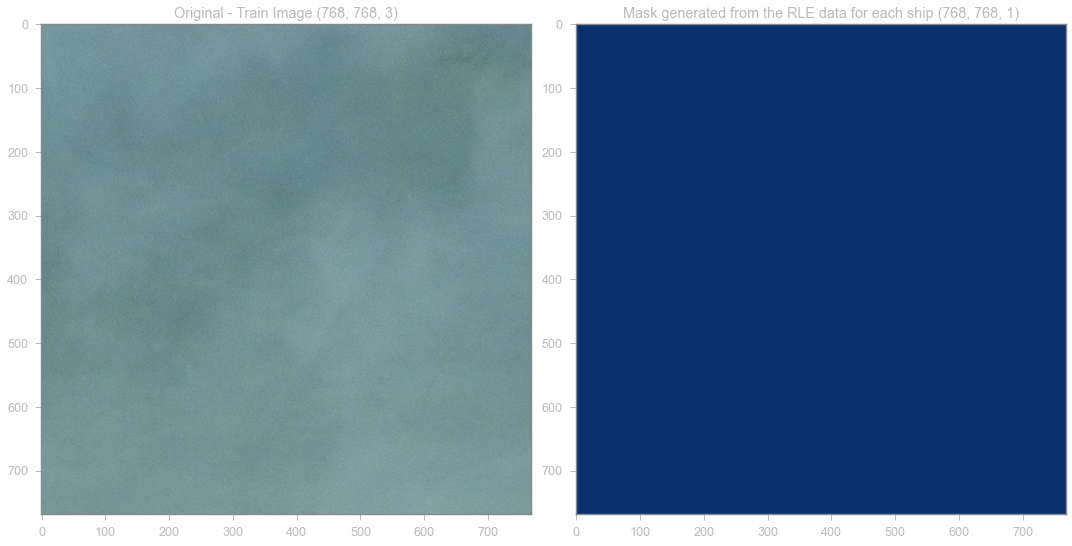

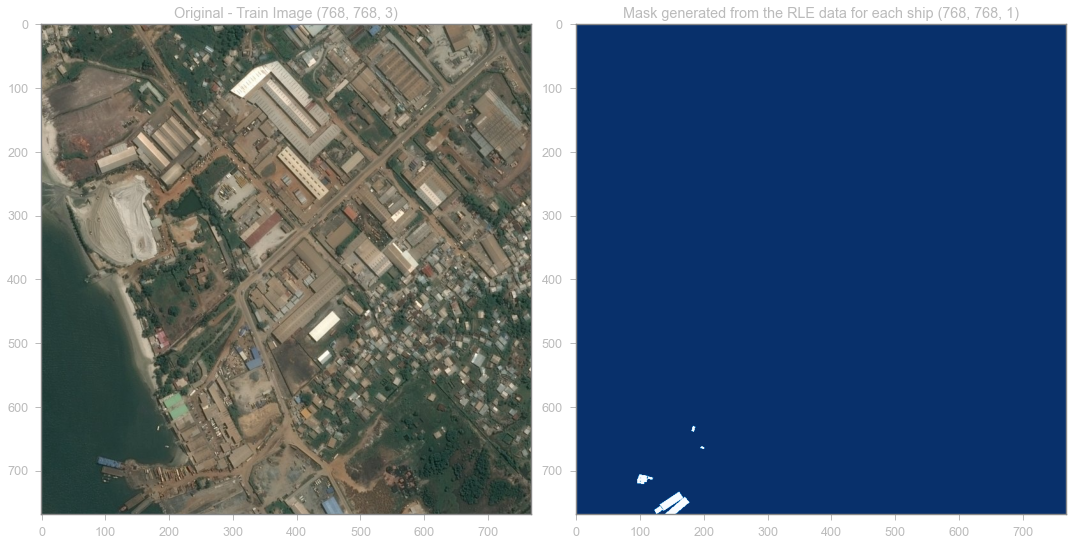

In [26]:
for num in [3, 4, 5, 6]:
    rle_0 = masks.query(f'ImageId=="{train_images[num-1]}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    original = imread(train_image_dir+"/"+train_images[num-1])
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - Train Image {original.shape}")
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.title(f"Mask generated from the RLE data for each ship {final.shape}")
    plt.imshow(img_0, cmap = "Blues_r")
    plt.tight_layout()
    plt.show()

In [27]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''   

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't. 
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

ImageId                                      EncodedPixels  ships
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      1
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...      1
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      1
8  0001b1832.jpg                                                NaN      0

In [28]:
# Making a new data frame with unique image ids where we are summing up the ship counts
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index() 
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head()

ImageId  ships
1  00003e153.jpg      0
2  0001124c7.jpg      0
3  000155de5.jpg      1
4  000194a2d.jpg      5
5  0001b1832.jpg      0

In [29]:
# Adding two new features to unique_img_ids data frame. If ship exists in image, val is 1 else 0. And it's vec form
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head()

ImageId  ships  has_ship
1  00003e153.jpg      0       0.0
2  0001124c7.jpg      0       0.0
3  000155de5.jpg      1       1.0
4  000194a2d.jpg      5       1.0
5  0001b1832.jpg      0       0.0

In [30]:
# Check the size of the files. Will take some time to run as there are loads of files!!!
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
'''os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'''

FileNotFoundError: [WinError 2] The system cannot find the file specified: "C:/Users/balur/OneDrive/Desktop/UTA/Sem-2/Network's/Project/train_v2\\000532683.jpg"